# Previsão de faturamento - Modelo autorregressivo ajustado ao produto `alimenticio`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento do produto `alimenticio` mês a mês.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# modelos
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Modelo autorregressivo - Faturamento do produto `alimenticio`

In [3]:
analise_produto = 'alimenticio'
fat = tswide['alimenticio'].dropna()

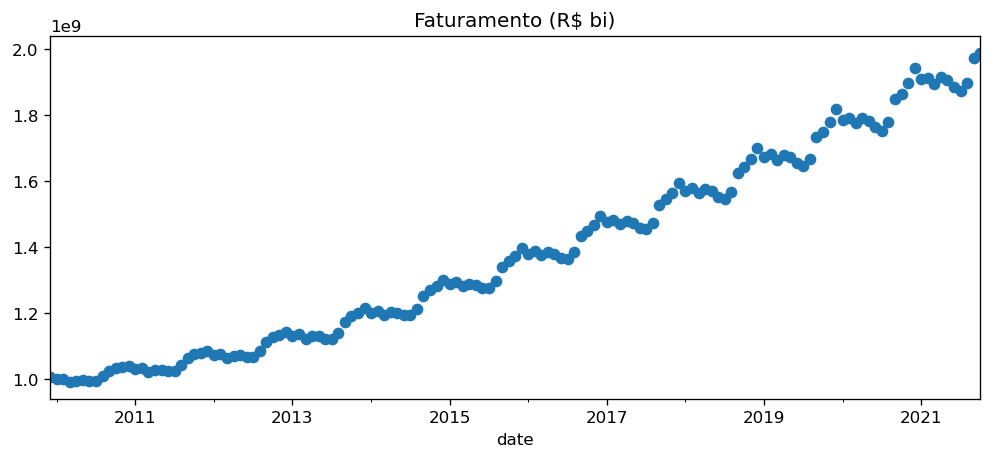

In [4]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

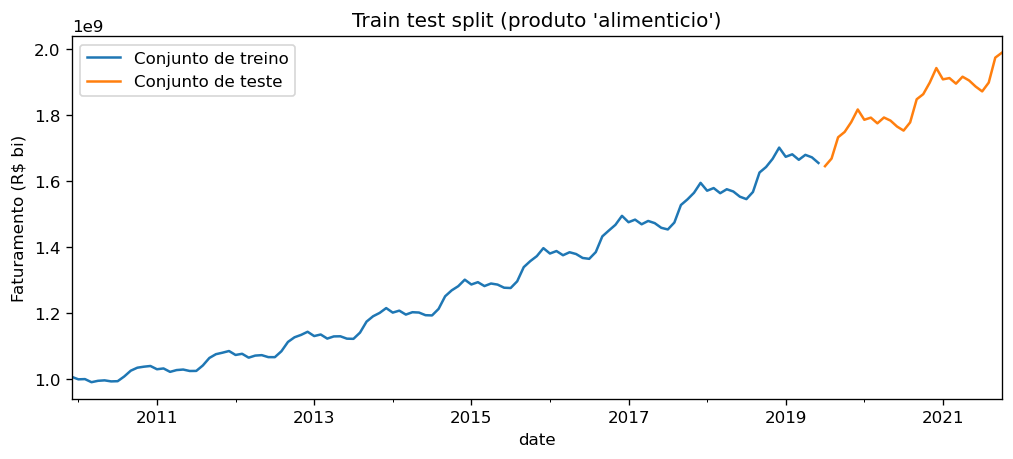

In [5]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

train_test_split_idx = int(fat.shape[0] * 0.8 + 1)
fat_train = fat[:train_test_split_idx]
fat_test = fat[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

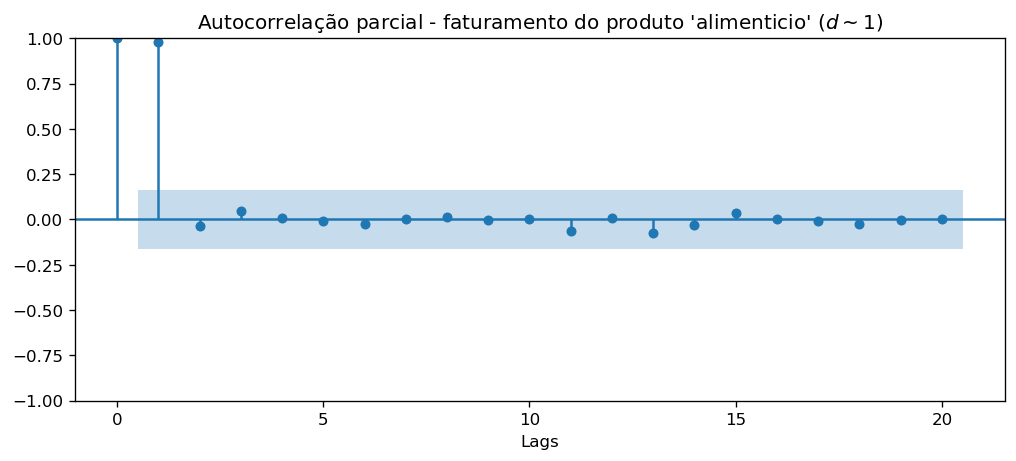

In [6]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d \sim 1$)")
plt.show()

In [7]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = 2, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )

In [8]:
modelo = ARIMA(order = (1, 2, 0), seasonal_order = (0, 2, 0, 12), with_intercept = False).fit(y = fat_train)

In [9]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 2, 0)x(0, 2, 0, 12)   Log Likelihood               -1329.655
Date:                            Sat, 20 Nov 2021   AIC                           2663.310
Time:                                    01:00:42   BIC                           2668.287
Sample:                                         0   HQIC                          2665.316
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0009      0.045      0.020      0.984      -0.087       0.089
sigma2      5.075e+11   5.86e-15   8.66e+25      0.000    5.08e+11    5.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               1.96   Skew:                             0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+42. Standard errors may be unstable.
"""

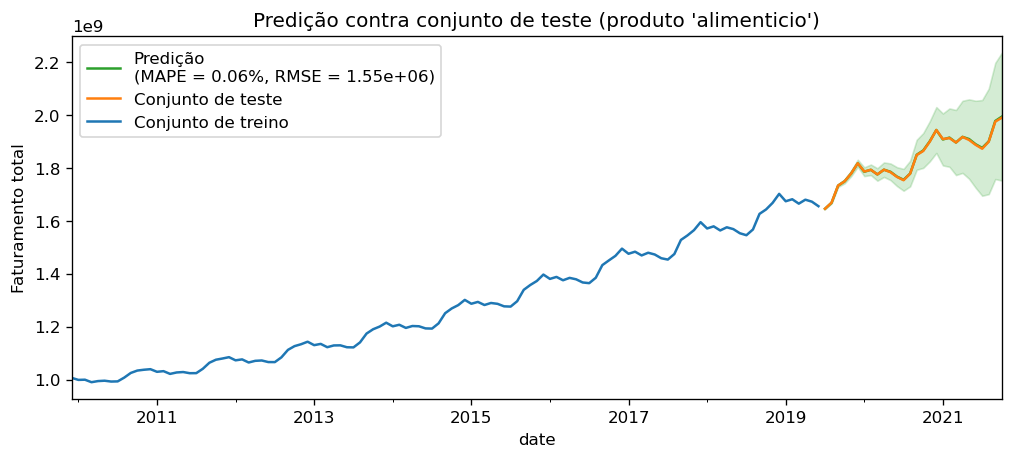

In [10]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test['2018-01':],
    ci = True,
    in_sample = False,
    preds_metrics = True
)

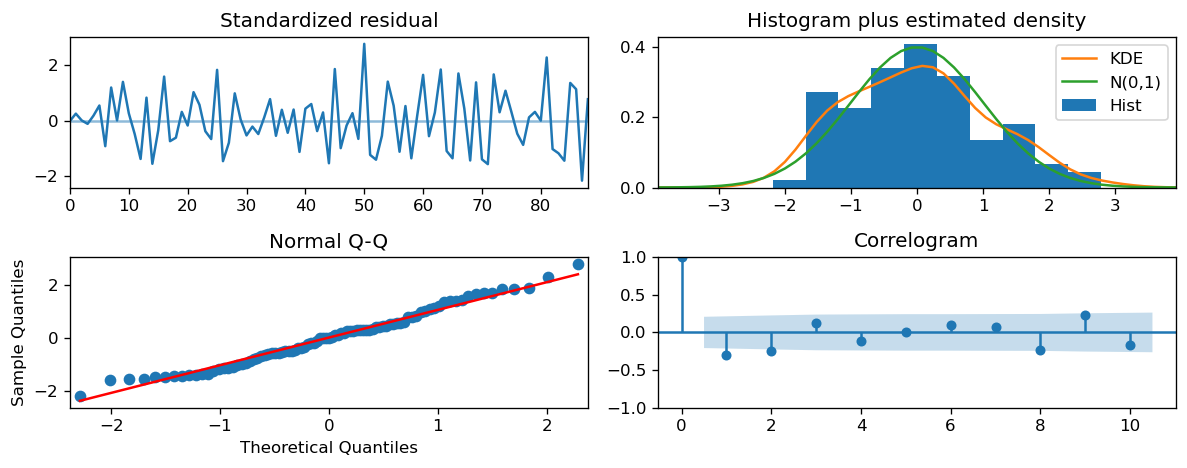

In [11]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [12]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.058%
       RMSE: 1.553e+06
        MAE: 1.087e+06


Vamos salvar o modelo atual para o faturamento do produto `alimenticio`.

In [14]:
modelo_dict = dict(
    modelo = modelo.fit(fat_train),
    serie_treino = fat_train,
)


# with open(r'../models/produto_alimenticio.model', 'wb') as arq_modelo_alimenticio:
#     pickler = pickle.Pickler(file = arq_modelo_alimenticio)
#     pickler.dump(modelo_dict)
